# Petit TP sur les réseaux de neurones convolutifs
La partie théorique est enfin terminée, bravo ! Je vous propose à présent de découvrir un petit TP sur la reconnaissance d’image grâce aux réseaux de neurones convolutifs, où nous verrons trois réseaux de neurones convolutifs de complexité différente.

# 1. Le problème
Pour cet exercice, nous allons créer un réseau de neurones convolutionnels capable de reconnaître les chiffres écrits à la main !

Le principe est simple : à partir d’une banque d’images de chiffres écrits à la main (et annoté pour dire de quel chiffre il s’agit), fournie par Keras (un framework de deep learning), nous allons entraîner 3 IA différentes et les comparer.



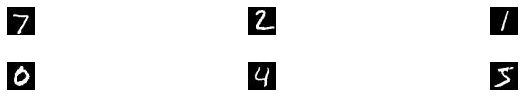



Dataset d’images de chiffres tracés à la main en 28×28 pixels : le MNIST (crédit : MNIST)

# Nos cibles de CNN
Voici le schéma d’architecture des réseaux de neurones que nous allons réaliser dans ce TP. Vous remarquerez un certain nombre de différences, qui aboutissent à des résultats plus ou moins bons. Les paramètres ont été sélectionnés à la fois par expérience et de manière empirique, car bien souvent on essaie plusieurs architectures avant de trouver la meilleure !

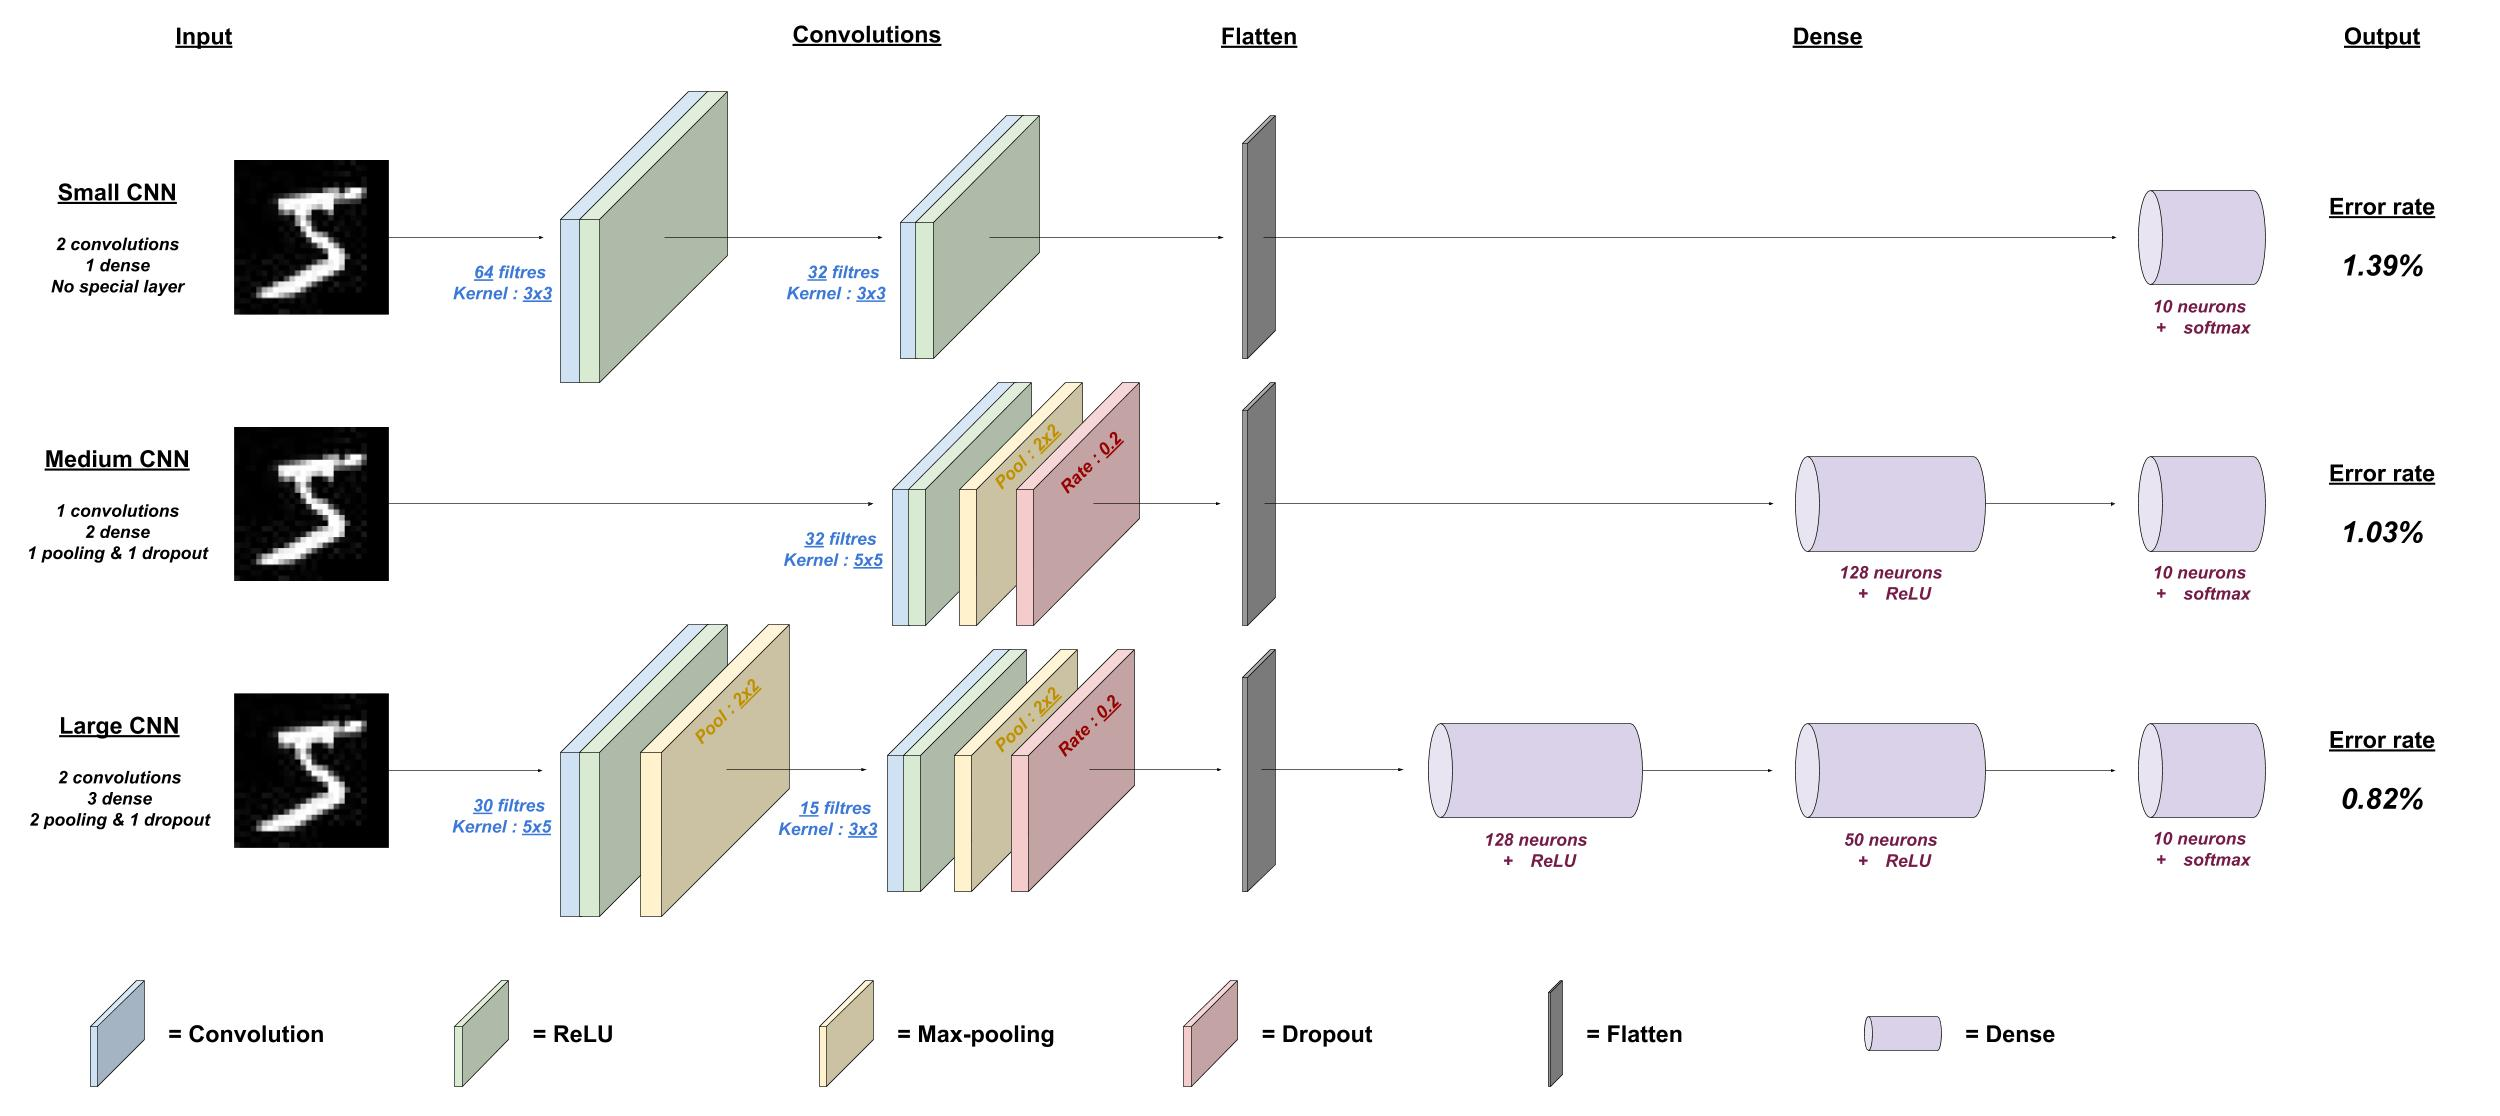TP CNN architecture
Trois CNN distincts pour un même problème : la reconnaissance de chiffres écrits à la main

# A. Les imports du « tp réseau de neurones convolutifs »
Nous allons utiliser les bibliothèques suivantes pour préparer nos données :
*   numpy : pour manipuler les vecteurs et interagir avec Keras, notre framework de Deep Learning. Cette bibliothèque est très largement employée.
*   keras : le framework de deep learning. L’import de Tensorflow en backend se fait automatiquement par Keras.

De Keras, on ne va prendre que le mnist (qui est le nom du dataset que l’on va utiliser), quelques utilitaires (dans np_utils), et le backend Tensorflow, nommé K, pour lequel on va spécifier le format de saisie des couches du modèle grâce à « channels_first ».

« channels_first » signifie que les kernels des convolutions auront pour format (depth, input_depth, rows, cols), à l’inverse de « channels_first » qui veut dire (rows, cols, input_depth, depth).

Dans Keras nous prendront cette fois le modèle, les couches (convolutions, pooling, etc…) et le backend pour en spécifier le format.

Ajoutez ainsi les lignes suivantes dans votre fichier :

In [76]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_first')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

Enfin, dans les deux fichiers, on va forcer le random de numpy : lors de la génération du modèle, de nombreux paramètres sont choisis aléatoirement par Keras via Numpy. Afin d’avoir exactement le même modèle (et donc les mêmes résultats), il est courant (DANS LES TUTORIAUX UNIQUEMENT) de fixer le random grâce à cette ligne (que vous devez donc ajouter).

In [77]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# B. La préparation des données
On attaque les choses sérieuses, puisqu’on va voir ensemble comment importer les données du MNIST et, surtout, quels traitements y apporter avant de les injecter dans notre CNN.

La partie « traitements » est généralement la plus importante (et négligée) en machine learning, car elle a un impact considérable sur les résultats des IA. 

Commençons par charger les données, qui sont

*   60 000 images d’apprentissages (matrices carrées de taille 28×28) en niveaux de gris (donc 1 seul channel)
*   Et 10 000 images de test (mêmes caractéristiques)
depuis le jeu de données du MNIST. 

Keras nous apprend également que toutes les images sont des chiffres uniques entre 0 et 9 inclus.

In [78]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [79]:

from skimage import io
import cv2 as cv 
from google.colab.patches import cv2_imshow
#Ajouter du code ici pour afficher quelques images de ce dataset
# Create a list to store the urls of the images
imgs=[
    'X_train[0]',
     'X_train[1]',
     'X_train[2]'
]
# Read and display the image
# loop over the image URLs, you could store several image urls in the list

cv2_imshow(X_train[0])
print('\n')
cv2_imshow(X_train[1])

cv2_imshow(X_train[2])
  

Ensuite, par rapport à notre configuration « th » de TensorFlow, il va falloir modifier légèrement la structure des matrices pour qu’elles soient utilisables dans le modèle.

On a pour l’instant du **60000x28x28**, et on voudrait du 60000x1x28x28 (nombre d’entrées, nombre de channels, largeur d’une entrée, hauteur d’une entrée). La commande « reshape » permet exactement de faire ça, à laquelle on ajoute « astype » pour convertir les matrices en float32 au lieu de uint8.

In [80]:
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

***Pourquoi convertir en float au lieu de garder des entiers ? ***

Dans la version no_preparation_small_cnn, on a conservé des entiers entre 0 et 255 alors que dans la version améliorée, on a converti en float avant de diviser par 255 (pour avoir des valeurs entre 0 et 1). Cette conversion et normalisation est une étape très importante de la préparation des données, car elle permet de réduire l’écart entre les valeurs extrêmes et d’éviter les overflow dans les calculs car des nombres supérieurs à 1 peuvent rapidement tendre vers l’infini si on n’est pas prudent.

Prenons un exemple pour se donner une idée de ce qu’il se passe : un pixel valant 200 par rapport à un pixel valant 50 aura une valeur 4 fois supérieure (ou un écart de +150). Dans un réseau de neurones classiques (plus facile à imaginer), on regarde pour un neurone donné tous les signaux qui y arrivent. Pour le neurone relié à notre 200 et notre 50, le pixel à 200 sera donc 4 fois plus important et dictera quasiment toutes les sorties de ce neurone, (ou alors il faudra un entraînement plus long pour que les poids s’équilibrent pour compenser ce x4 / +150). A l’inverse, si les données sont normalisées, la valeur reste toujours 4 fois supérieure MAIS l’écart est très faible. Une liaison entre les neurones peut donc facilement compenser cette différence si besoin, avec moins d’entraînement et plus d’efficacité/justesse.

Pour plus de détails sur l’importance de la normalisation, n’hésitez pas à consulter l’article sur le perceptron multi-couches.

Ajoutons le code pour normaliser les valeurs :

In [81]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Enfin, dernier point, on va travailler les vecteurs de sorties pour qu’ils reflètent la valeur prédite par le réseau. En effet, il serait très compliqué (voire impossible de manière efficace et juste) d’avoir un CNN qui nous renverrait un seul et unique résultat entre 0 et 9 valant le chiffre détecté dans l’image. A l’inverse, il est plus facile pour un CNN de nous donner la probabilité que ce soit un 0, la probabilité que ce soit un 1, etc… jusqu’à 9.

Cette conversion des variables catégoricielle se fait facilement, grâce au système de « one hot encode » :

In [82]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

A noter que num_classes représente le nombre de valeurs de sorties du CNN.

Pour conclure, je vous propose d’encapsuler toute cette préparation des données dans une seule et même méthode, qui sera appelée par nos CNN en amont, et qui retournera nos différentes variables. Vous devriez avoir ceci au final :

In [83]:
def get_and_prepare_data_mnist():
    # load data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # reshape to be [samples][pixels][width][height]
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
    
    
    # normalize inputs from 0-255 to 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    # one hot encode outputs
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    return (X_train, y_train), (X_test, y_test), num_classes

**C. Le modèle de CNN**

Les données étant prêtes, on va travailler notre « Small CNN » conformément au schéma d’architecture présenté en début de partie.

Pour commencer, chargeons les données grâce à la méthode get_and_prepare_data_mnist:

In [84]:
# import MNIST dataset
(X_train, y_train), (X_test, y_test), num_classes = get_and_prepare_data_mnist()

Pour déclarer un nouveau modèle de deep learning dans Keras, on utilise l’instruction suivante, qui vaut aussi bien pour des ANN que des CNN qu’autre chose :

In [85]:
model = Sequential()

Ensuite, les méthodes à appeler sont très parlantes. Rappelons que notre objectif est d’avoir successivement :

*   Une convolution de 64 filtres en 3×3 suivie d’une couche d’activation ReLU
*   Une convolution de 32 filtres en 3×3 suivie d’une couche d’activation ReLU
*   Un flatten qui va créer le vecteur final à envoyer au réseau de neurones artificiels (alias dense)
*   Un dense, réseau de neurones artificiels qui aura 10 neurones et sera suivi d’un softmax
Remarque : softmax est une fonction mathématique qui permet de normaliser un vecteur pour en faire des probabilités (grosso modo).

Pour déclarer une convolution, la syntaxe est d’appeler Conv2D avec en paramètres le nombre de filtres, les dimensions du noyau (3×3), en précisant input_shape : la taille des données d’entrée (uniquement sur la 1ère couche du CNN) et enfin l’activation.

Pourquoi Conv2D et pas juste « Conv » ? Dans Keras, la possibilité existe d’utiliser des convolutions à 1, 2 ou 3 dimensions (ainsi que les convolutions spéciales vues dans le paragraphe dédié). Comme on l’a dit, les convolutions s’appliquent séparément à chaque channel de l’image. Elles sont donc en 2D et non en 3D !

Le Flatten ne prend aucun paramètre, car il n’y a besoin de rien de particulier pour mettre toutes les images bout à bout.

En revanche, le Dense qui sert à déclarer notre réseau de neurones artificiels prend en paramètre le nombre de neurones de la couche de sortie, et offusque tout le reste (sauf le paramètre « activation » qui vaut ici softmax).

Avec ces indications et quelques recherches dans la bibliographie Keras, vous devriez pouvoir écrire la construction du Small CNN sinon la voici :

In [86]:
# create model
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(1, 28, 28), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

Dernière étape dans la déclaration de notre modèle : il faut le compiler via « model.compile » en précisant les informations suivantes, intrinsèques au réseau de neurones convolutifs…

*   le loss : c’est une fonction qui va servir à mesurer l’écart entre les prédictions de notre IA et les résultats attendus. Elle évalue donc la justesse du CNN et permet de mieux l’adapter aux données si besoin ! Nous allons utiliser « categorical_crossentropy » comme loss, car on a des données de type « catégories » en sortie de l’algorithme.
*   l’optimizer : c’est un algorithme qui va dicter comment mettre à jour le CNN pour diminuer le loss, et avoir donc de meilleures prédictions. Ici on s’appuiera sur « adam » (adaptive moment estimation), très souvent utilisé.
*   la metrics : c’est exactement comme le loss, sauf que la metrics n’est PAS utilisée par le CNN, à l’inverse du loss qui sert pour la mise à jour des variables du CNN via l’optimizer. On utilisera cette fois « accuracy », sans que cela ait de réelle importance pour nous.

Au final, en encapsulant le code dans une méthode, vous devriez avoir ceci :

In [87]:
# define the small model
def small_model():
    # create model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(1, 28, 28), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

**ATTENTION : lorsque vous chargez un modèle Keras déjà entraîné, il faut impérativement le compiler pour qu’il soit utilisable !**

# D. L’entraînement et l’évaluation du Small CNN
Félicitations, vous avez créé votre modèle de bout en bout ! Il ne nous reste plus qu’à lancer l’entraînement !

Commençons par le créer grâce à la méthode précédente :

In [88]:
# build the model
model = small_model()

Pour entraîner un modèle, il suffit d’appeler la méthode fit qui prend en arguments :

*   Les données d’apprentissage, ici X_train
*   Les prédictions attendues d’apprentissage, ici y_train
*   Le paramètre validation_data : un vecteur qui contient les données d’entrées à tester et les valeurs à prédire, ici (X_test , y_test)
*   Le nombre d’itérations de l’entraînement, c’est-à-dire le nombre de fois qu’il va répéter l’entraînement complet (prédire les 60 000 images), via epochs. Je vous propose de mettre 10 (nombre empirique à déterminer en testant : le « loss » ne diminue plus significativement après la 9ème itération, mais on pourrait continuer)
*   Et enfin le paramètre batch_size, qui est le nombre de données d’entrées à analyser « à la suite avant de mettre à jour le CNN », qui vaudra 200 (valeur standard). L’intérêt est que mettre à jour son CNN après chaque image demande du temps et a tendance à nous éloigner de la solution générale optimale (je rappelle qu’on veut un CNN capable d’identifier n’importe quel chiffre dessiné, pas seulement ceux de l’entraînement). En indiquant 200, on s’assure que le réseau ne se spécialise « pas trop »

**Vous pouvez activer l'exécution sous GPU depuis le menu de Goggle Colab: Exécution--> Modifier le type d'exécution--> Accélérateur MAtériel pour réduire le temps d'exécution.**

Ce qui donne le code suivant :

In [89]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

Epoch 1/10
300/300 [==============================] - 4s 13ms/step - loss: 0.2209 - accuracy: 0.9368 - val_loss: 0.0680 - val_accuracy: 0.9795
Epoch 2/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0637 - accuracy: 0.9810 - val_loss: 0.0532 - val_accuracy: 0.9833
Epoch 3/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0444 - accuracy: 0.9866 - val_loss: 0.0537 - val_accuracy: 0.9833
Epoch 4/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0331 - accuracy: 0.9899 - val_loss: 0.0460 - val_accuracy: 0.9863
Epoch 5/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0243 - accuracy: 0.9922 - val_loss: 0.0458 - val_accuracy: 0.9864
Epoch 6/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.0484 - val_accuracy: 0.9863
Epoch 7/10
300/300 [==============================] - 4s 14ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 0.0504 - val_accuracy: 0.9869

Maintenant, nous allons implémenter les méthodes qui permettent d'évaluer le modèle (« evaluate » permet d’évaluer un modèle comme son nom l’indique (plusieurs informations sont remontées par Keras). Pour avoir le taux d’erreur, il suffit de prendre 100% – le taux de succès (scores[1]).)

D'autres méthodes seront aussi implémentées pour enregistrer ou charger le modèle.

In [90]:
from keras.models import model_from_json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# This function saves a model on the drive using two files : a json and an h5
def save_keras_model(model, filename):
    # serialize model to JSON
    model_json = model.to_json()
    with open(filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(filename+".h5")
    
# This function loads a model from two files : a json and a h5
# BE CAREFUL : the model NEEDS TO BE COMPILED before any use !
def load_keras_model(filename):
    # load json and create model
    json_file = open(filename+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(filename+".h5")
    return loaded_model

# Evaluate a model using data and expected predictions
def print_model_error_rate(model, X_test, y_test):
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Model score : %.2f%%" % (scores[1]*100))
    print("Model error rate : %.2f%%" % (100-scores[1]*100))
    
# Save a data image to a real image on your desktop
def export_image_from_dataset(data, filename):
    im = Image.fromarray(data)
    im.save(filename)

# Instead of saving the data image, it is displayed in console thanks to matplotlib 
def plot_image_from_dataset(data):
    plt.imshow(data, cmap=plt.get_cmap('gray'))
   
# Load an image and converts it to array, for usage in models
def import_custom_image_to_dataset(filename):
    #Load image in grayscale
    img = Image.open(filename).convert('L')
    #Resize like other images in dataset
    img = img.resize((28,28), Image.ANTIALIAS)
    #Convert to array
    x =  np.array(img)
    #Reshape
    x = x.reshape(1,28,28,1).astype('float32')
    #Normalize
    x = x / 255
    
    plt.imshow(x, cmap=plt.get_cmap('gray'))
    return x

Il ne nous reste plus qu’à évaluer notre modèle, grâce à la commande:

In [91]:

# Evaluate the model
print_model_error_rate(model, X_test, y_test)

Model score : 98.62%
Model error rate : 1.38%


Le « medium CNN »
Grâce à notre découpage du code, il va être très rapide de changer l’architecture de notre CNN. A vrai dire, la seule chose que nous allons changer est… le contenu de la méthode small_model() !

Dupliquez le fichier small-cnn-tutorial-keras.py.

Renommez small_model en medium_model puis changeons ensemble la structure du CNN.

Pour rappel, notre objectif est d’avoir :

*   Une convolution de 32 filtres en 5×5 avec un ReLU en sortie (n’oubliez pas le paramètre input_shape)
*   Un max-pooling de 2×2
*   Un dropout de 0.2
*   Un flatten
*   Un dense à 128 sorties avec un ReLU
*   Un dense final à 10 sorties avec un softmax

Par rapport au small CNN, il vous manque le max-pooling et le dropout pour tout coder.

Le max-pooling est ajouté grâce à MaxPooling2D, comme vous vous en doutez, qui prend en paramètre les dimensions du pooling (2,2) dans le paramètre pool_size.

Le dropout pour sa part est ajouté via Dropout, qui reçoit directement le taux de dropout (i.e. 0.2). Cela signifie que 20% des neurones seront ignorés, comme expliqué précédemment.

Voici le code final de la méthode créant le medium CNN :

In [92]:
# define the medium model
def medium_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Evaluez le modèle dans la cellule suivante:

In [94]:
# build the model
model = medium_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

# print_model_error_rate(model, X_test, y_test)
print_model_error_rate(model, X_test, y_test)

Epoch 1/10
300/300 [==============================] - 2s 6ms/step - loss: 0.2394 - accuracy: 0.9328 - val_loss: 0.0806 - val_accuracy: 0.9764
Epoch 2/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0723 - accuracy: 0.9789 - val_loss: 0.0476 - val_accuracy: 0.9862
Epoch 3/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0516 - accuracy: 0.9847 - val_loss: 0.0394 - val_accuracy: 0.9875
Epoch 4/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0405 - accuracy: 0.9872 - val_loss: 0.0381 - val_accuracy: 0.9881
Epoch 5/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0325 - accuracy: 0.9903 - val_loss: 0.0374 - val_accuracy: 0.9879
Epoch 6/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.0392 - val_accuracy: 0.9877
Epoch 7/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.0352 - val_accuracy: 0.9878
Epoch 

Le « large CNN »
Pour le large CNN, on va dupliquer le medium CNN et changer la méthode medium_cnn en large_cnn. Voici l’architecture cible, pour laquelle vous avez toutes les billes à disposition !

*   Une convolution de 30 filtres en 5×5 avec une activation ReLU (n’oubliez pas l’input_shape)
*   Un max-pooling de 2×2
*   Une convolution de 15 filtres en 3×3 avec ReLU
*   Un dropout de 0.2
*   Un flatten
*   Un dense de 128 sorties avec ReLU
*   Un dense de 50 sorties avec ReLU
*   Un dense de 10 sorties avec softmax

Voici le code complet de la méthode :

In [72]:
# define the larger model
def large_model():
    # create model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(1, 28, 28), activation='relu'))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    #Compléter le modèle ici
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Evaluez le modèle dans la cellule suivante:

In [95]:
#Evaluate the large Model
# build the model
model = large_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

# print_model_error_rate(model, X_test, y_test)
print_model_error_rate(model, X_test, y_test)

Epoch 1/10
300/300 [==============================] - 5s 16ms/step - loss: 0.2477 - accuracy: 0.9245 - val_loss: 0.0537 - val_accuracy: 0.9829
Epoch 2/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0624 - accuracy: 0.9798 - val_loss: 0.0335 - val_accuracy: 0.9892
Epoch 3/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0437 - accuracy: 0.9863 - val_loss: 0.0263 - val_accuracy: 0.9907
Epoch 4/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0353 - accuracy: 0.9889 - val_loss: 0.0252 - val_accuracy: 0.9918
Epoch 5/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0284 - accuracy: 0.9909 - val_loss: 0.0252 - val_accuracy: 0.9920
Epoch 6/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0232 - accuracy: 0.9925 - val_loss: 0.0283 - val_accuracy: 0.9918
Epoch 7/10
300/300 [==============================] - 4s 12ms/step - loss: 0.0216 - accuracy: 0.9927 - val_loss: 0.0250 - val_accuracy: 0.9919

In [105]:

import tensorflow as tf
#Essayer le modèle large sur les images fournies dans le dossier
X=[X_train[0],X_train[1]]
predictions=model.predict(X_train)

tf.nn.softmax(predictions[0])
#plt.imshow( X_train[0])


tf.nn.softmax(predictions[1])


1875/1875 [==============================] - 4s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.09942441, 0.10119927, 0.09934307, 0.09910525, 0.10043364,
       0.10044026, 0.09938911, 0.10047286, 0.10005065, 0.1001414 ],
      dtype=float32)>